# About

See what BERT is all about. This version is meant to run on our server.

replication of the following blog post:

### News Topic Similarity Measure using Pretrained BERT Model

https://medium.com/the-artificial-impostor/news-topic-similarity-measure-using-pretrained-bert-model-1dbfe6a66f1d

https://github.com/ceshine/pytorch-pretrained-BERT/blob/master/notebooks/Next%20Sentence%20Prediction.ipynb

https://anaconda.org/conda-forge/pytorch-pretrained-bert

### various implementations of BERT

https://pypi.org/project/pytorch-pretrained-bert/

https://github.com/huggingface/transformers

https://github.com/tensorflow/models/tree/master/official/nlp/bert

https://github.com/google-research/bert

https://anaconda.org/akode/bert-tensorflow

using the hugging face one, is most popular in conda downloads, and is the one used by the blog author

https://github.com/huggingface/pytorch-pretrained-BERT

https://anaconda.org/conda-forge/pytorch-pretrained-bert


### Understanding searches better than ever before

google's white paper

https://www.blog.google/products/search/search-language-understanding-bert

### bert_en_uncased_L-12_H-768_A-12

BERT on tensorflow hub

https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1

# News Topic Similarity Measure using Pretrained BERT Model

replication

Might want to add a CUDA device to the server

https://www.infoworld.com/article/3299703/what-is-cuda-parallel-programming-for-gpus.html

https://cloud.google.com/compute/docs/gpus/

https://cloud.google.com/compute/docs/gpus/add-gpus

https://cloud.google.com/products/calculator/

# loads our wrapper classes

we're not using NYTimes article feed
instead of the News Title vs News Body, we have Question Title vs Question Body

and we're going to make it similar to Grace's framework, so it will be easier for Chi to adapt

In [150]:
class Suggester_BertTopicSimiliarty():
    def __init__(
        self
        , question_file
        , answer_file
        , sample_n
        , random_state
        , bert_cache
        , logger
        , device
        , max_seq_length
        , batch_size
    ):
        # initializes some vars
        self.question_file = question_file
        self.answer_file = answer_file
        self.sample_n = sample_n
        self.random_state = random_state
        self.bert_cache = bert_cache
        self.logger = logger
        self.device = device
        self.max_seq_length = max_seq_length
        self.batch_size = batch_size
        
        # gets the pre-trained tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(
            "bert-base-uncased"
            , do_lower_case = True
            , cache_dir = self.bert_cache
        )
        
        # gets the pre-trained model
        self.model = BertForNextSentencePrediction.from_pretrained(
            "bert-base-uncased"
            , cache_dir = self.bert_cache
        ).to(self.device)
        
        # instantiates the helper class
        self.ceshiner = Ceshiner()
    
    
    def _construct_corpus(self, questions, answers):
        '''
        helper function that constructs corpus
        with question id, title, accepted answer id, answer body
        note, implicitly only questions with accepted answers will end up in corpus
        '''
        t1 = questions[[
            "id"
            , "title"
            , "tags"
            , "accepted_answer_id"
        ]].rename(columns = {
            "id" : "q_id"
            , "title" : "q_title"
        })

        t2 = answers[[
            "id"
            , "body"
            , "images_list"
            , "code_snippets"
            , "cleaned_body"
        ]].rename(columns = {
            "id" : "a_id"
            , "body" : "a_body"
            , "images_list" : "a_images_list"
            , "code_snippets" : "a_code_snippets"
            , "cleaned_body" : "a_cleaned_body"
        })

        t3 = t1.merge(
            t2
            , left_on = "accepted_answer_id"
            , right_on = "a_id"
            , how = "inner"
        ).drop(columns = "a_id")
        
        # ... removes any cleaned answers that are null
        t4 = t3[t3.a_cleaned_body.notnull()]

        if self.sample_n is not None:
            t5 = t4.sample(self.sample_n, random_state = self.random_state)
        else:
            t5 = t4

        return(t5)
    
    
    def prepare(self):
        '''
        loads data & makes corpus
        '''
        self.questions = pd.read_csv(self.question_file, delimiter = "\t", encoding = "utf-8")
        self.answers = pd.read_csv(self.answer_file, delimiter = "\t", encoding = "utf-8")
        self.corpus = self._construct_corpus(self.questions, self.answers)
        print(self.corpus.shape)
    
    def get_similar_documents(self, query, num_results = 5, threshold = 0.10):
        sentence_pairs = self.ceshiner.convert_sentence_pair(
            [query] * self.corpus.shape[0]
            , self.corpus.a_cleaned_body.tolist()
            , max_seq_length = self.max_seq_length
            , tokenizer = self.tokenizer
        )
        self.similarity_scores = self.ceshiner.eval_pairs(
            sentence_pairs = sentence_pairs
            , batch_size = self.batch_size
            , model = self.model
        )
        similarity_above_threshold = self.similarity_scores[self.similarity_scores >= threshold]
        res = np.argsort(similarity_above_threshold)[::-1][:num_results]
        self.best_matches = self.corpus.iloc[res]
        similar_que = self.best_matches["q_title"]
        similar_ans = self.best_matches["a_cleaned_body"]
        return(similar_que, similar_ans)


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target
        
        
class Ceshiner():
    def __init__(self):
        pass
    
    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()
                
    def convert_sentence_pair(self, titles, descs, max_seq_length, tokenizer):
        features = []
        for (ex_index, (title, desc)) in enumerate(zip(titles, descs)):
            tokens_a = tokenizer.tokenize(title)
            
            tokens_b = None
            tokens_b = tokenizer.tokenize(desc)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

            # The convention in BERT is:
            # (a) For sequence pairs:
            #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
            #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
            # (b) For single sequences:
            #  tokens:   [CLS] the dog is hairy . [SEP]
            #  type_ids: 0   0   0   0  0     0 0
            #
            # Where "type_ids" are used to indicate whether this is the first
            # sequence or the second sequence. The embedding vectors for `type=0` and
            # `type=1` were learned during pre-training and are added to the wordpiece
            # embedding vector (and position vector). This is not *strictly* necessary
            # since the [SEP] token unambigiously separates the sequences, but it makes
            # it easier for the model to learn the concept of sequences.
            #
            # For classification tasks, the first vector (corresponding to [CLS]) is
            # used as as the "sentence vector". Note that this only makes sense because
            # the entire model is fine-tuned.
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
            segment_ids = [0] * len(tokens)

            if tokens_b:
                tokens += tokens_b + ["[SEP]"]
                segment_ids += [1] * (len(tokens_b) + 1)

            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            padding = [0] * (max_seq_length - len(input_ids))
            input_ids += padding
            input_mask += padding
            segment_ids += padding

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            if ex_index < 5:
                logger.info("*** Example ***")
                logger.info("tokens: %s" % " ".join(
                        [str(x) for x in tokens]))
                logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
                logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
                logger.info(
                        "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

            features.append(
                    InputFeatures(
                        input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        target=1
            ))
        return features
    
    def eval_pairs(self, sentence_pairs, batch_size, model):
        logger.info("***** Running evaluation *****")
        all_input_ids = torch.tensor([f.input_ids for f in sentence_pairs], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in sentence_pairs], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in sentence_pairs], dtype=torch.long)
        eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
        # Run prediction for full data
        eval_sampler = SequentialSampler(eval_data)
        eval_dataloader = DataLoader(eval_data, sampler = eval_sampler, batch_size = batch_size)

        logger.info("  Num examples = %d", len(sentence_pairs))
        logger.info("  Batch size = %d", batch_size)

        model.eval()

        res = []

        mb = progress_bar(eval_dataloader)
        for input_ids, input_mask, segment_ids in mb:
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)

            with torch.no_grad():
                res.append(nn.functional.softmax(
                    model(input_ids, segment_ids, input_mask), dim=1
                )[:, 0].detach().cpu().numpy())

        res = np.concatenate(res)
        return(res)

In [151]:
# i.e. app.py

import gcsfs
import os
import logging
import random
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import gc
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert.tokenization import BertTokenizer
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit


# defines seed for replication
SEED = 20191114

# defines cache folder for BERT model
PYTORCH_PRETRAINED_BERT_CACHE = "../models/bert/"

SAMPLE_SIZE = 600
BATCH_SIZE = 128
MAX_SEQ_LENGTH = 200

# creates a logger
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")


# detects the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# sets random states
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)


# this uses gcsfs library
# fs = gcsfs.GCSFileSystem(project='w210-jcgy-254100')
# p_base_dir = "w210-jcgy-bucket/w210-data-output-new-q-and-a-files-with-separate-cleaned-answer-bodies"
# p_questions = os.path.join(p_base_dir, "PostQuestionsFiltered_V4_parsed.tsv")
# p_answers = os.path.join(p_base_dir, "PostAnswersFiltered_V4_cleaned_answer_bodies.tsv")
# with fs.open(p_questions, 'rb') as f_q:
#     with fs.open(p_answers, 'rb') as f_a:
#         m = tfModel_BertTopicSimiliarty(f_q, f_a)

# this relies on bucket being mounted, might be a bit faster to load the files
p_base_dir = "/mnt/disks/w210-jcgy-bucket/w210-data-output-new-q-and-a-files-with-separate-cleaned-answer-bodies"
p_questions = os.path.join(p_base_dir, "PostQuestionsFiltered_V4_parsed.tsv")
p_answers = os.path.join(p_base_dir, "PostAnswersFiltered_V4_cleaned_answer_bodies.tsv")
m = Suggester_BertTopicSimiliarty(
    p_questions
    , p_answers
    , sample_n = SAMPLE_SIZE
    , random_state = SEED
    , bert_cache = PYTORCH_PRETRAINED_BERT_CACHE
    , logger = logger
    , device = device
    , max_seq_length = MAX_SEQ_LENGTH
    , batch_size = BATCH_SIZE
)

11/15/2019 08:54:43 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at ../models/bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
11/15/2019 08:54:43 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../models/bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
11/15/2019 08:54:43 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file ../models/bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmp2bjagt38
11/15/2019 08:54:47 - INFO - pytorch_pretrained_bert.modeling -   Model config {

In [152]:
# loads data and builds a corpus
m.prepare()

(600, 8)


In [ ]:
# gets similar queries
similar_que, similar_ans = m.get_similar_documents(query = "this is a query", num_results = 10)

11/15/2019 08:55:21 - INFO - bert -   *** Example ***
11/15/2019 08:55:21 - INFO - bert -   tokens: [CLS] this is a query [SEP] you can add option category ##ord ##er in your v ##bar statement : i found it here : http : / / blogs . sas . com / content / graphical ##ly ##sp ##eak ##ing / 2012 / 06 / 07 / bar - chart - with - response - sort / # pretty ##ph ##oto [SEP]
11/15/2019 08:55:21 - INFO - bert -   input_ids: 101 2023 2003 1037 23032 102 2017 2064 5587 5724 4696 8551 2121 1999 2115 1058 8237 4861 1024 1045 2179 2009 2182 1024 8299 1024 1013 1013 23012 1012 21871 1012 4012 1013 4180 1013 20477 2135 13102 25508 2075 1013 2262 1013 5757 1013 5718 1013 3347 1011 3673 1011 2007 1011 3433 1011 4066 1013 1001 3492 8458 11439 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/15/2019 08:55:21 - INFO - bert -   input_ids: 101 2023 2003 1037 23032 102 10262 2115 4654 8586 23056 2003 2315 1000 2026 1035 2565 1000 1010 1998 2009 1005 1055 1999 1996 1000 1013 29379 1013 3347 1013 2139 8569 2290 1000 14176 1024 2065 2017 4995 1005 1056 2469 2129 2000 2424 1996 2565 5371 2993 1010 2017 2064 2157 1011 11562 2009 1006 1045 1012 1041 1012 1024 1996 1000 4031 1000 1007 1998 1000 2265 1999 2424 2121 1000 2004 3491 1999 2023 12117 12326 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/15/2019 08:55:21 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# checks

In [139]:
m.corpus.head(3)

,q_id,q_title,tags,accepted_answer_id,a_body,a_images_list,a_code_snippets,a_cleaned_body
170490,46148697,How do I order the bars of a bar chart by heig...,sasbar-chart,46151020.0,<p>You can add option <strong>categoryorder</s...,"[<img alt=""enter image description here"" src=""...",[<code>proc sgplot data = dat;\r\r\n vbar tx...,You can add option categoryorder in your vbar...
216601,33806543,"is an ""optionalized"" pipe operator idiomatic F#",f#pipelineidiomatic,33806972.0,<p>I think using Option.map would be more idio...,[],[],I think using Option.map would be more idioma...
123768,8396101,Invert image displayed by imshow in matplotlib,pythonimagematplotlib,8396124.0,<p>Specify the keyword argument <code>origin='...,[],"[<code>origin='lower'</code>, <code>origin='up...",Specify the keyword argument or in your call ...


In [140]:
# using the tokenizer on the unclean answer body tends to have odd single characters
m.tokenizer.tokenize(m.corpus.iloc[1].a_body)

['<',
 'p',
 '>',
 'i',
 'think',
 'using',
 'option',
 '.',
 'map',
 'would',
 'be',
 'more',
 'id',
 '##iom',
 '##atic',
 ':',
 '<',
 '/',
 'p',
 '>',
 '<',
 'block',
 '##qu',
 '##ote',
 '>',
 '<',
 'p',
 '>',
 'let',
 'g',
 'x',
 '=',
 'x',
 '|',
 '>',
 'into',
 '##ption',
 '|',
 '>',
 'option',
 '.',
 'map',
 'foo',
 '|',
 '>',
 'option',
 '.',
 'map',
 'bar',
 '<',
 '/',
 'p',
 '>',
 '<',
 '/',
 'block',
 '##qu',
 '##ote',
 '>']

In [141]:
m.tokenizer.tokenize(m.corpus.iloc[1].a_cleaned_body)

['i',
 'think',
 'using',
 'option',
 '.',
 'map',
 'would',
 'be',
 'more',
 'id',
 '##iom',
 '##atic',
 ':',
 'let',
 'g',
 'x',
 '=',
 'x',
 '|',
 '>',
 'into',
 '##ption',
 '|',
 '>',
 'option',
 '.',
 'map',
 'foo',
 '|',
 '>',
 'option',
 '.',
 'map',
 'bar']

In [142]:
sentence_pairs = m.ceshiner.convert_sentence_pair(
    titles = m.corpus.q_title.tolist()
    , descs = m.corpus.a_cleaned_body.tolist()
    , max_seq_length = 200
    , tokenizer = m.tokenizer
)

11/15/2019 08:48:29 - INFO - bert -   *** Example ***
11/15/2019 08:48:29 - INFO - bert -   tokens: [CLS] how do i order the bars of a bar chart by height rather than alphabet ##ically [SEP] you can add option category ##ord ##er in your v ##bar statement : i found it here : http : / / blogs . sas . com / content / graphical ##ly ##sp ##eak ##ing / 2012 / 06 / 07 / bar - chart - with - response - sort / # pretty ##ph ##oto [SEP]
11/15/2019 08:48:29 - INFO - bert -   input_ids: 101 2129 2079 1045 2344 1996 6963 1997 1037 3347 3673 2011 4578 2738 2084 12440 15004 102 2017 2064 5587 5724 4696 8551 2121 1999 2115 1058 8237 4861 1024 1045 2179 2009 2182 1024 8299 1024 1013 1013 23012 1012 21871 1012 4012 1013 4180 1013 20477 2135 13102 25508 2075 1013 2262 1013 5757 1013 5718 1013 3347 1011 3673 1011 2007 1011 3433 1011 4066 1013 1001 3492 8458 11439 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/15/2019 08:48:29 - INFO - bert -   *** Example ***
11/15/2019 08:48:29 - INFO - bert -   tokens: [CLS] x ##code command line tool - how to run in terminal ? [SEP] assuming your ex ##ec ##utable is named " my _ program " , and it ' s in the " / foo / bar / de ##bu ##g " directory : if you aren ' t sure how to find the program file itself , you can right - click it ( i . e . : the " product " ) and " show in find ##er " as shown in this screens ##hot : [SEP]
11/15/2019 08:48:29 - INFO - bert -   input_ids: 101 1060 16044 3094 2240 6994 1011 2129 2000 2448 1999 5536 1029 102 10262 2115 4654 8586 23056 2003 2315 1000 2026 1035 2565 1000 1010 1998 2009 1005 1055 1999 1996 1000 1013 29379 1013 3347 1013 2139 8569 2290 1000 14176 1024 2065 2017 4995 1005 1056 2469 2129 2000 2424 1996 2565 5371 2993 1010 2017 2064 2157 1011 11562 2009 1006 1045 1012 1041 1012 1024 1996 1000 4031 1000 1007 1998 1000 2265 1999 2424 2121 1000 2004 3491 1999 2023 12117 12326 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [144]:
m.similarity_scores

array([0.9999635 , 0.9999807 , 0.99998915, 0.99990284, 0.9999708 ,
       0.9999167 , 0.99996996, 0.99998784, 0.99990034, 0.99997663],
      dtype=float32)

In [81]:
sentence_pairs_2 = m.ceshiner.convert_sentence_pair(
    titles = ["this is a query"] * m.corpus.shape[0]
    , descs = m.corpus.a_cleaned_body.tolist()
    , max_seq_length = 200
    , tokenizer = m.tokenizer
)

11/15/2019 07:35:07 - INFO - bert -   *** Example ***
11/15/2019 07:35:07 - INFO - bert -   tokens: [CLS] this is a query [SEP] you can add option category ##ord ##er in your v ##bar statement : i found it here : http : / / blogs . sas . com / content / graphical ##ly ##sp ##eak ##ing / 2012 / 06 / 07 / bar - chart - with - response - sort / # pretty ##ph ##oto [SEP]
11/15/2019 07:35:07 - INFO - bert -   input_ids: 101 2023 2003 1037 23032 102 2017 2064 5587 5724 4696 8551 2121 1999 2115 1058 8237 4861 1024 1045 2179 2009 2182 1024 8299 1024 1013 1013 23012 1012 21871 1012 4012 1013 4180 1013 20477 2135 13102 25508 2075 1013 2262 1013 5757 1013 5718 1013 3347 1011 3673 1011 2007 1011 3433 1011 4066 1013 1001 3492 8458 11439 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/15/2019 07:35:08 - INFO - bert -   input_ids: 101 2023 2003 1037 23032 102 10262 2115 4654 8586 23056 2003 2315 1000 2026 1035 2565 1000 1010 1998 2009 1005 1055 1999 1996 1000 1013 29379 1013 3347 1013 2139 8569 2290 1000 14176 1024 2065 2017 4995 1005 1056 2469 2129 2000 2424 1996 2565 5371 2993 1010 2017 2064 2157 1011 11562 2009 1006 1045 1012 1041 1012 1024 1996 1000 4031 1000 1007 1998 1000 2265 1999 2424 2121 1000 2004 3491 1999 2023 12117 12326 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/15/2019 07:35:08 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [82]:
sentence_pairs_2

In [83]:
len(sentence_pairs_2)

10

In [145]:
print(similar_que)

123768       Invert image displayed by imshow in matplotlib
47204     How to perform undirected graph processing fro...
216601      is an "optionalized" pipe operator idiomatic F#
170929                          ChartJS with Dynamic Colors
78853     Xcode command line tool - how to run in terminal?
Name: q_title, dtype: object


In [146]:
print(similar_ans)

123768     Specify the keyword argument or in your call ...
47204      Ok, here's my stab at the problem. Here's a s...
216601     I think using Option.map would be more idioma...
170929     You are looking for something like the follow...
78853      Assuming your executable is named "my_program...
Name: a_cleaned_body, dtype: object


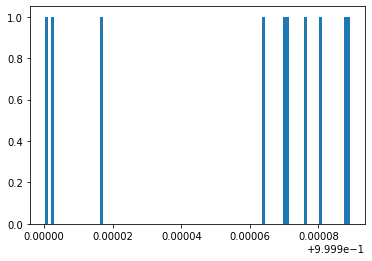

In [147]:
_ = plt.hist(m.similarity_scores, bins = 100)

In [148]:
sum(m.similarity_scores > 0.99) / len(m.similarity_scores), sum(m.similarity_scores > 0.9) / len(m.similarity_scores), sum(m.similarity_scores < 0.5) / len(m.similarity_scores)

(1.0, 1.0, 0.0)

In [149]:
m.best_matches

,q_id,q_title,tags,accepted_answer_id,a_body,a_images_list,a_code_snippets,a_cleaned_body
123768,8396101,Invert image displayed by imshow in matplotlib,pythonimagematplotlib,8396124.0,<p>Specify the keyword argument <code>origin='...,[],"[<code>origin='lower'</code>, <code>origin='up...",Specify the keyword argument or in your call ...
47204,2807151,How to perform undirected graph processing fro...,sqlgraphactivemq,2807579.0,"<p>Ok, here's my stab at the problem. </p>\r\r...",[],[<code>[nodes]\r\r\nnode : varchar(xx)\r\r\n\r...,"Ok, here's my stab at the problem. Here's a s..."
216601,33806543,"is an ""optionalized"" pipe operator idiomatic F#",f#pipelineidiomatic,33806972.0,<p>I think using Option.map would be more idio...,[],[],I think using Option.map would be more idioma...
170929,46118401,ChartJS with Dynamic Colors,chart.js,46118932.0,<p><strong>You are looking for something like ...,[],"[<code>var chart = new Chart(ctx, {\r\r\n ty...",You are looking for something like the follow...
78853,19554822,Xcode command line tool - how to run in terminal?,xcodecommand-line,19554870.0,"<p>Assuming your executable is named ""my_progr...","[<img alt=""enter image description here"" src=""...",[<code>cd /foo/bar\r\r\n./my_program\r\r\n</co...,"Assuming your executable is named ""my_program..."
